In [189]:
%run functions.py
% run archive/silhouette_plotter.py

In [190]:
table = 'eth-tokens.test.clean_avg_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [191]:
df, dflabel = load_data_from_bigquery(table, label_table)

In [192]:
results = data_pipeline(df)

In [193]:
# #trying out feature scaling to see if we get better separation
# df['incoming_std_time_btwn_txns'] = df['incoming_std_time_btwn_txns']/df['incoming_avg_time_btwn_txns']
# df['outgoing_std_time_btwn_txns'] = df['outgoing_std_time_btwn_txns']/df['outgoing_avg_time_btwn_txns']
# results = data_pipeline(df)

In [194]:
cl = cluster(results, n_clusters=8)

In [195]:
assign_cluster_to_data(df, dflabel, cl)

In [8]:
tsne_results = calc_tsne(results, perplexity=50,n_iter=1000)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 35917 samples in 0.027s...
[t-SNE] Computed neighbors for 35917 samples in 13.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35917
[t-SNE] Computed conditional probabilities for sample 2000 / 35917
[t-SNE] Computed conditional probabilities for sample 3000 / 35917
[t-SNE] Computed conditional probabilities for sample 4000 / 35917
[t-SNE] Computed conditional probabilities for sample 5000 / 35917
[t-SNE] Computed conditional probabilities for sample 6000 / 35917
[t-SNE] Computed conditional probabilities for sample 7000 / 35917
[t-SNE] Computed conditional probabilities for sample 8000 / 35917
[t-SNE] Computed conditional probabilities for sample 9000 / 35917
[t-SNE] Computed conditional probabilities for sample 10000 / 35917
[t-SNE] Computed conditional probabilities for sample 11000 / 35917
[t-SNE] Computed conditional probabilities for sample 12000 / 35917
[t-SNE] Computed conditional probabilities for s

/home/ubuntu/ethereum_clustering/functions.py:97: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


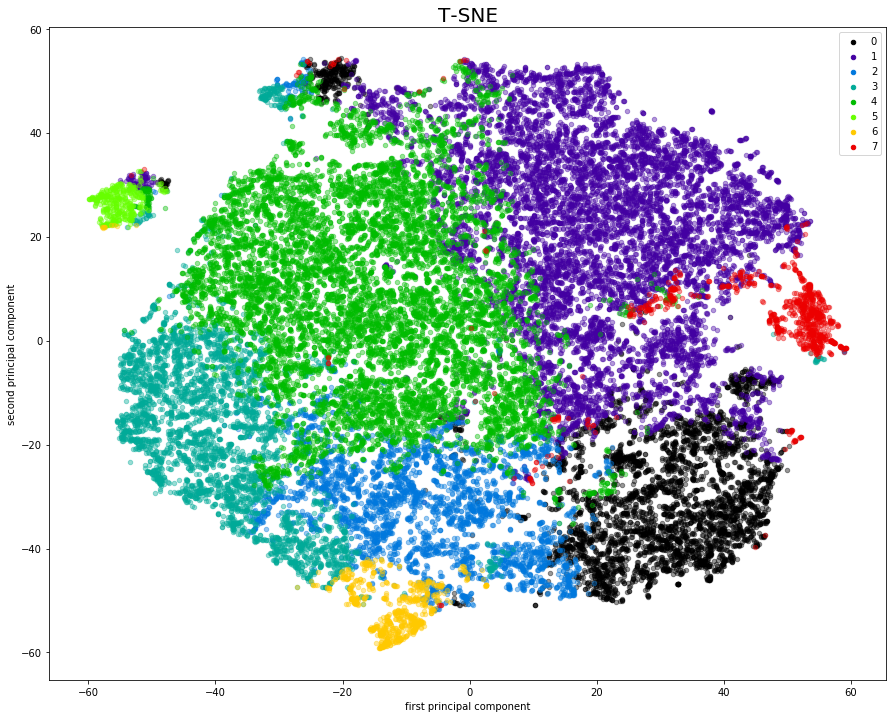

In [196]:
plot_tsne(cl, tsne_results)

In [197]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining', 'ICO Wallets')
colors = ('green', 'blue', 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(cl,dflabel, category=c)

clusters= list(d.values())

Exchange
cluster number   0   number of type found: 0    cluster size: 4733   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 10600   label density: 0.0
cluster number   2   number of type found: 1    cluster size: 3764   label density: 0.00026567481402763017
cluster number   3   number of type found: 2    cluster size: 4145   label density: 0.0004825090470446321
cluster number   4   number of type found: 0    cluster size: 10638   label density: 0.0
cluster number   5   number of type found: 5    cluster size: 399   label density: 0.012531328320802004
cluster number   6   number of type found: 45    cluster size: 708   label density: 0.0635593220338983
cluster number   7   number of type found: 0    cluster size: 930   label density: 0.0
Mining
cluster number   0   number of type found: 0    cluster size: 4733   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 10600   label density: 0.0
cluster number   2   number of typ

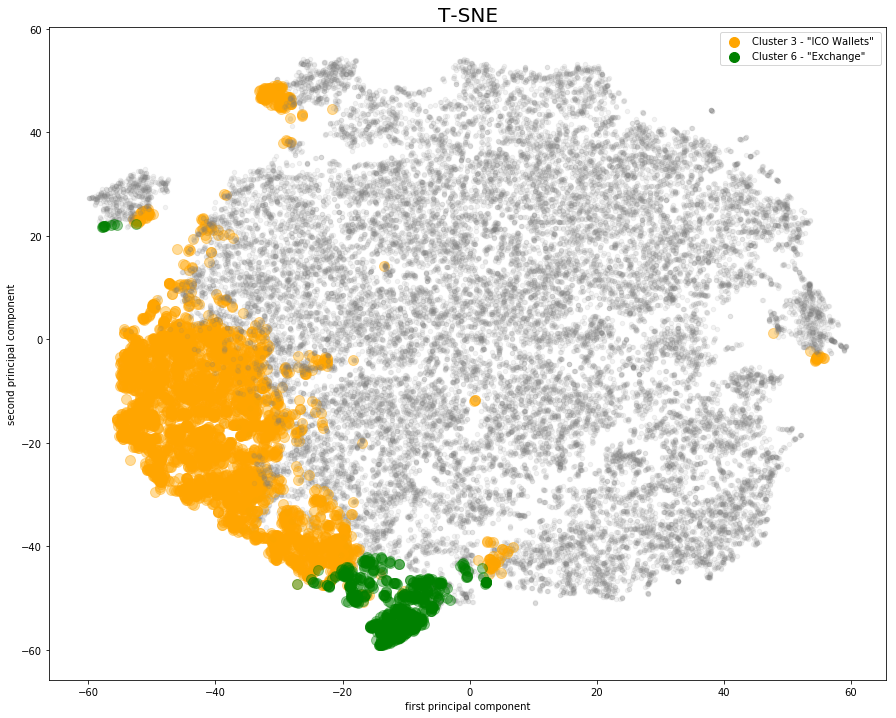

In [198]:
plot_tsne_with_labeled_clusters(tsne_results, cl, clusters, categs, colors)

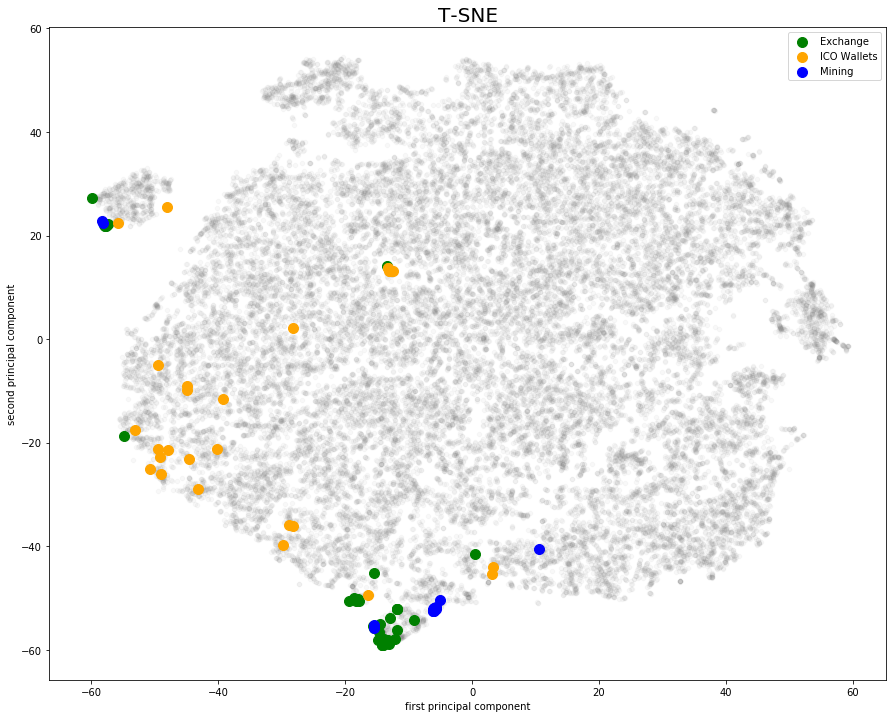

In [199]:
plot_tsne_with_labels(tsne_results,df, dflabel,categs,colors)

In [200]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining')#, 'ICO Wallets')
colors = ('green', 'blue')#, 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(cl,dflabel, category=c)

clusters= list(d.values())

Exchange
cluster number   0   number of type found: 0    cluster size: 4733   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 10600   label density: 0.0
cluster number   2   number of type found: 1    cluster size: 3764   label density: 0.00026567481402763017
cluster number   3   number of type found: 2    cluster size: 4145   label density: 0.0004825090470446321
cluster number   4   number of type found: 0    cluster size: 10638   label density: 0.0
cluster number   5   number of type found: 5    cluster size: 399   label density: 0.012531328320802004
cluster number   6   number of type found: 45    cluster size: 708   label density: 0.0635593220338983
cluster number   7   number of type found: 0    cluster size: 930   label density: 0.0
Mining
cluster number   0   number of type found: 0    cluster size: 4733   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 10600   label density: 0.0
cluster number   2   number of typ

In [201]:
#recluster with only clusters of interest - will help with separation

subcl, subresults, newdf = recluster(df, cl, clusters, n_clusters=3)

In [202]:
sub_tsne_results = calc_tsne(subresults)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 708 samples in 0.001s...
[t-SNE] Computed neighbors for 708 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 708 / 708
[t-SNE] Mean sigma: 1.432590
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.891758
[t-SNE] KL divergence after 300 iterations: 0.823309
t-SNE done! Time elapsed: 1.4799325466156006 seconds


In [203]:
assign_cluster_to_data(newdf, dflabel, subcl)

In [204]:
#highlighting clusters of interest

d = {}
for c in categs:
    d[c] = find_category_of_cluster(subcl,dflabel, category=c)

subclusters= list(d.values())

Exchange
cluster number   0   number of type found: 2    cluster size: 336   label density: 0.005952380952380952
cluster number   1   number of type found: 9    cluster size: 208   label density: 0.04326923076923077
cluster number   2   number of type found: 34    cluster size: 164   label density: 0.2073170731707317
Mining
cluster number   0   number of type found: 9    cluster size: 336   label density: 0.026785714285714284
cluster number   1   number of type found: 0    cluster size: 208   label density: 0.0
cluster number   2   number of type found: 2    cluster size: 164   label density: 0.012195121951219513


/home/ubuntu/ethereum_clustering/functions.py:97: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


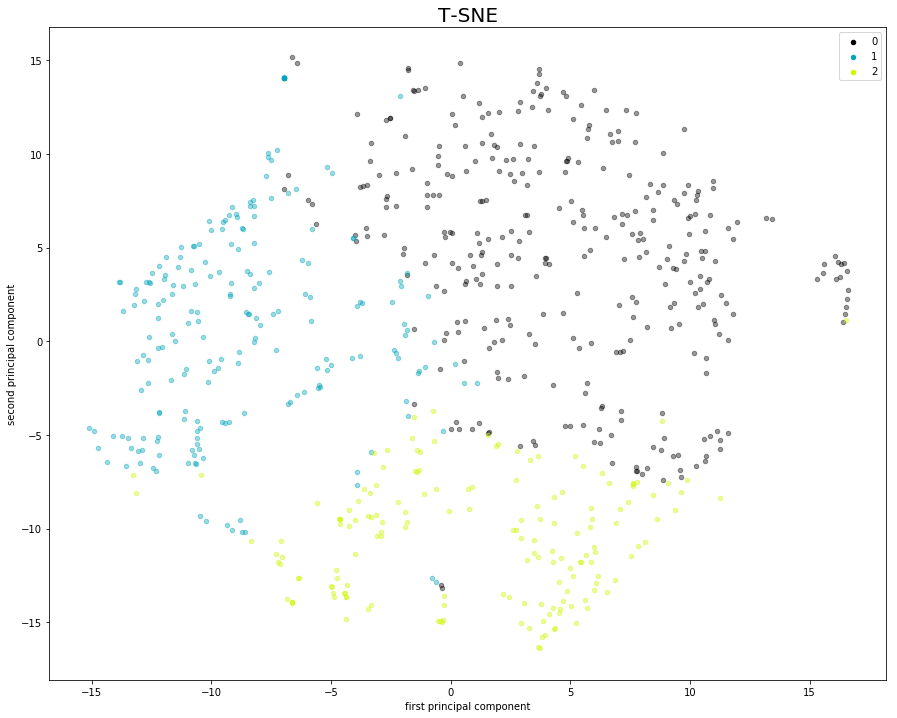

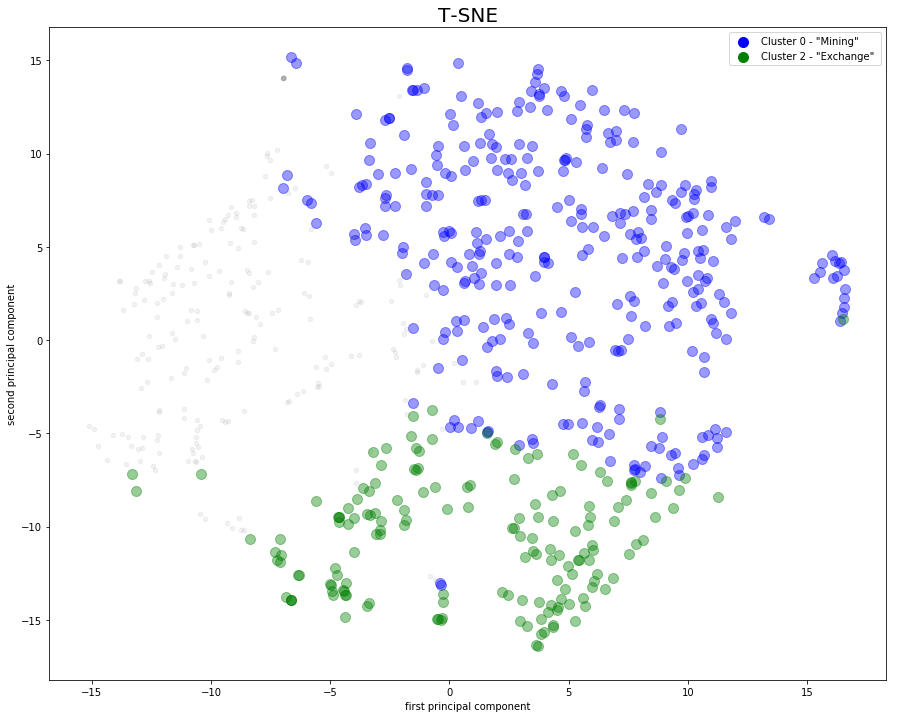

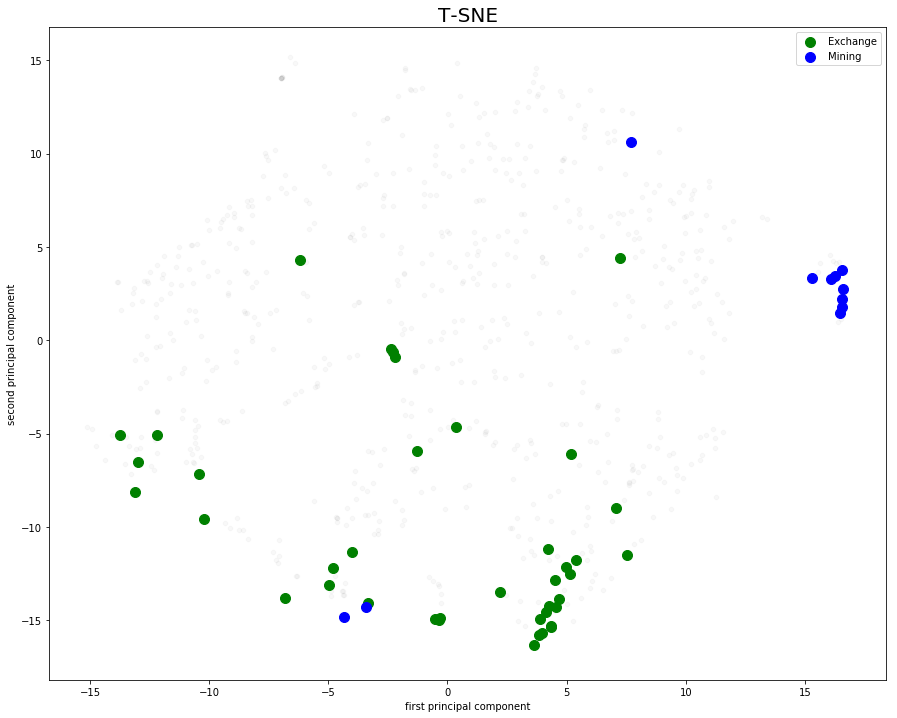

In [205]:
plot_all(sub_tsne_results,subcl,newdf,dflabel,subclusters,categs,colors )


In [206]:
# %run supervised.py
# target = "Exchange"
# predictions = get_predictions(df, dflabel, target)

# plot_predictions(tsne_results,predictions)

In [207]:
mask = (cl.labels_==999)
for c in clusters:
    mask |= (cl.labels_==c)
np.sum(mask)

708

In [208]:
import copy

In [209]:
lbls = copy.deepcopy(cl.labels_)

In [210]:
lbls[mask] =  [100+subcl.labels_[i] for i in range(len(subcl.labels_))]

In [211]:
lbls

array([  0,   2,   3, ...,   2,   2, 100], dtype=int32)

In [212]:
clnew = copy.deepcopy(cl)

In [213]:
clnew.labels_=lbls

In [214]:
mask = np.array([c not in clusters for c in np.unique(cl.labels_) ])
clnew.cluster_centers_ = clnew.cluster_centers_[mask]

In [215]:
clnew.n_clusters=cl.n_clusters - len(np.unique(clusters)) + subcl.n_clusters

In [216]:
clnew.cluster_centers_ = np.vstack((clnew.cluster_centers_, subcl.cluster_centers_))

In [217]:
assign_cluster_to_data(df, dflabel, clnew)

In [218]:
#highlighting clusters of interest
categs = ('Exchange', 'Mining', 'ICO Wallets')
colors = ('green', 'blue', 'orange')

d = {}
for c in categs:
    d[c] = find_category_of_cluster(clnew,dflabel, category=c)

clusters= list(d.values())

Exchange
cluster number   0   number of type found: 0    cluster size: 4733   label density: 0.0
cluster number   1   number of type found: 0    cluster size: 10600   label density: 0.0
cluster number   2   number of type found: 1    cluster size: 3764   label density: 0.00026567481402763017
cluster number   3   number of type found: 2    cluster size: 4145   label density: 0.0004825090470446321
cluster number   4   number of type found: 0    cluster size: 10638   label density: 0.0
cluster number   5   number of type found: 5    cluster size: 399   label density: 0.012531328320802004
cluster number   7   number of type found: 0    cluster size: 930   label density: 0.0
cluster number   100   number of type found: 2    cluster size: 336   label density: 0.005952380952380952
cluster number   101   number of type found: 9    cluster size: 208   label density: 0.04326923076923077
cluster number   102   number of type found: 34    cluster size: 164   label density: 0.2073170731707317
Minin

/home/ubuntu/ethereum_clustering/functions.py:97: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


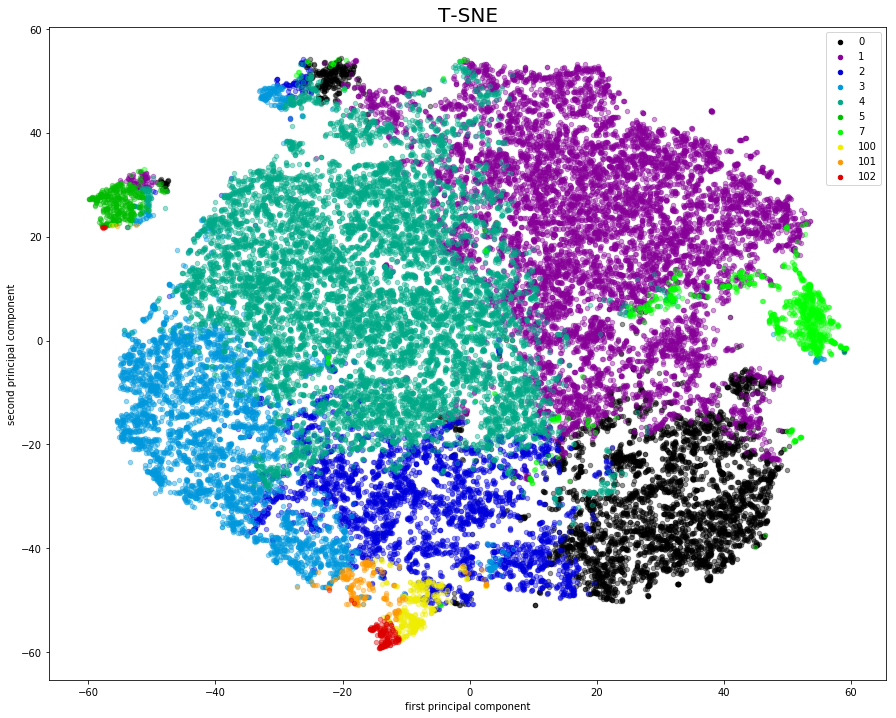

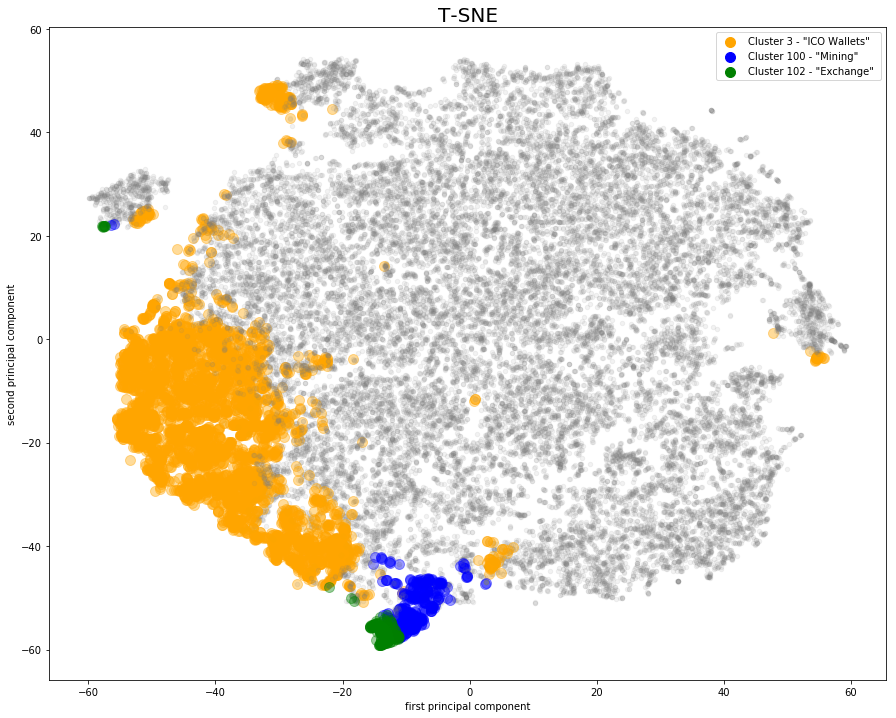

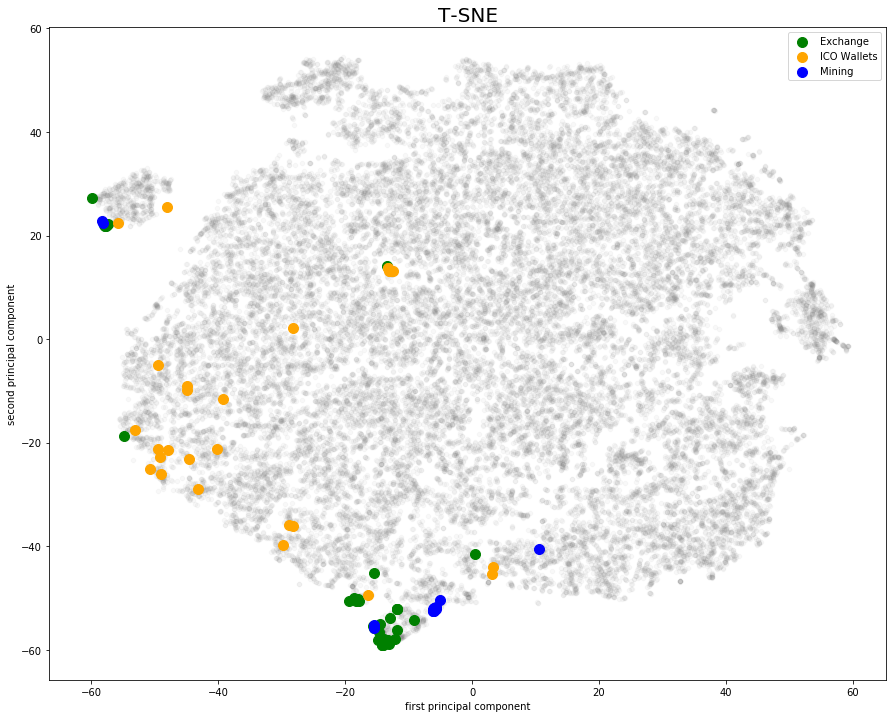

In [219]:
plot_all(tsne_results,clnew,df,dflabel,clusters,categs,colors )

## Pickle results

In [220]:
import pickle
pickle.dump(clnew, open( "pickles/cl.p", "wb" ) )
pickle.dump(clusters, open( "pickles/clusters.p", "wb" ) )
pickle.dump(categs, open( "pickles/categs.p", "wb" ) )
pickle.dump(colors, open( "pickles/colors.p", "wb" ) )
pickle.dump(df, open( "pickles/df.p", "wb" ) )
pickle.dump(dflabel, open( "pickles/dflabel.p", "wb" ) )
# pickle.dump(labeled_addresses, open( "pickles/labeled_addresses.p", "wb" ) )
# pickle.dump(cats, open( "pickles/cats.p", "wb" ) )
# pickle.dump(not_subset, open( "pickles/not_subset.p", "wb" ) )
# pickle.dump(labelmask, open( "pickles/labelmask.p", "wb" ) )